# 04__activities
# analyzing activity levels per element (neg ctrls; between biotypes)

in this notebook, i perform analyses examining the activities of reference tiles in both pool1 and pool2. i compare reference sequences to negative controls, examine reference activities between biotypes, examine how MPRA activity compares to CAGE expression, and determine how many sequences are expressed across cell types.

------

figures in this notebook:
- **Fig 1C, Fig S4A, Fig S8**: boxplots comparing reference sequences to negative controls
- **Fig 1D, Fig S4B**: boxplots comparing activities between biotypes
- **Fig 1E**: KDE plot comparing CAGE cell type specificity and MPRA cell type specificity
- **Fig 1F**: barplot showing % of reference sequences active in 1 or all 3 cell types

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time

from itertools import chain
from decimal import Decimal
from scipy import stats
from statsmodels.sandbox.stats import multicomp

# import utils
sys.path.append("../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *

%matplotlib inline

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## variables

In [3]:
activ_dir = "../../data/02__activs"
pval_dir = "../../data/03__pvals"
index_dir = "../../data/00__index"

In [4]:
pool1_hela_barc_activ_f = "POOL1__pMPRA1__HeLa__activities_per_barcode.txt"
pool1_hepg2_barc_activ_f = "POOL1__pMPRA1__HepG2__activities_per_barcode.txt"
pool1_k562_barc_activ_f = "POOL1__pMPRA1__K562__activities_per_barcode.txt"

pool1_hela_elem_activ_f = "POOL1__pMPRA1__HeLa__activities_per_element.txt"
pool1_hepg2_elem_activ_f = "POOL1__pMPRA1__HepG2__activities_per_element.txt"
pool1_k562_elem_activ_f = "POOL1__pMPRA1__K562__activities_per_element.txt"

pool1_hela_pvals_f = "POOL1__pMPRA1__HeLa__pvals.txt"
pool1_hepg2_pvals_f = "POOL1__pMPRA1__HepG2__pvals.txt"
pool1_k562_pvals_f = "POOL1__pMPRA1__K562__pvals.txt"

In [5]:
pool1_nocmv_hela_barc_activ_f = "POOL1__pNoCMVMPRA1__HeLa__activities_per_barcode.txt"
pool1_nocmv_hepg2_barc_activ_f = "POOL1__pNoCMVMPRA1__HepG2__activities_per_barcode.txt"
pool1_nocmv_k562_barc_activ_f = "POOL1__pNoCMVMPRA1__K562__activities_per_barcode.txt"

pool1_nocmv_hela_elem_activ_f = "POOL1__pNoCMVMPRA1__HeLa__activities_per_element.txt"
pool1_nocmv_hepg2_elem_activ_f = "POOL1__pNoCMVMPRA1__HepG2__activities_per_element.txt"
pool1_nocmv_k562_elem_activ_f = "POOL1__pNoCMVMPRA1__K562__activities_per_element.txt"

pool1_nocmv_hela_pvals_f = "POOL1__pNoCMVMPRA1__HeLa__pvals.txt"
pool1_nocmv_hepg2_pvals_f = "POOL1__pNoCMVMPRA1__HepG2__pvals.txt"
pool1_nocmv_k562_pvals_f = "POOL1__pNoCMVMPRA1__K562__pvals.txt"

In [6]:
pool2_hepg2_barc_activ_f = "POOL2__pMPRA1__HepG2__activities_per_barcode.txt"
pool2_k562_barc_activ_f = "POOL2__pMPRA1__K562__activities_per_barcode.txt"

pool2_hepg2_elem_activ_f = "POOL2__pMPRA1__HepG2__activities_per_element.txt"
pool2_k562_elem_activ_f = "POOL2__pMPRA1__K562__activities_per_element.txt"

pool2_hepg2_pvals_f = "POOL2__pMPRA1__HepG2__pvals.txt"
pool2_k562_pvals_f = "POOL2__pMPRA1__K562__pvals.txt"

In [7]:
pool1_index_f = "%s/tss_oligo_pool.index.txt" % index_dir
pool2_index_f = "%s/dels_oligo_pool.index.txt" % index_dir

In [8]:
annot_f = "../../misc/00__tss_properties/mpra_id_to_biotype_map.txt"
id_map_f = "../../misc/00__tss_properties/mpra_tss_detailed_info.txt"
enh_id_map_f = "../../misc/00__tss_properties/enhancer_id_map.txt"
sel_map_f = "../../misc/00__tss_properties/mpra_tss_selection_info.txt"
cage_exp_f = "../../misc/other_files/All_TSS_and_enh.CAGE_grouped_exp.tissue_sp.txt"

## 1. import data

In [9]:
pool1_index = pd.read_table(pool1_index_f, sep="\t")
pool2_index = pd.read_table(pool2_index_f, sep="\t")

In [10]:
pool1_index_elem = pool1_index[["element", "oligo_type", "unique_id", "dupe_info", "SNP"]]
pool2_index_elem = pool2_index[["element", "oligo_type", "unique_id", "dupe_info", "SNP"]]

pool1_index_elem = pool1_index_elem.drop_duplicates()
pool2_index_elem = pool2_index_elem.drop_duplicates()

In [11]:
annot = pd.read_table(annot_f, sep="\t")
annot.head()

,seqID,PromType2
0,WILDTYPE__Antisense.noflip.NA__chr1:100435456....,div_lnc
1,WILDTYPE__Lincrna.flip.sense__chr1:100731637.....,div_lnc
2,FLIPPED__Lincrna.flip.antisense__chr1:10073163...,div_lnc
3,FLIPPED__mrna.flip.antisense__chr1:100731714.....,div_pc
4,WILDTYPE__mrna.flip.sense__chr1:100731714..100...,div_pc


In [12]:
id_map = pd.read_table(id_map_f, sep="\t")
id_map.head()

,gene_id,TSS_associated_1st.transc_id,oligo_reg,TSS_id,TSS_description,TSS_transc_association,avExpALL,gene_name,gene_type,GeneType,...,rs.SNP1,rs.SNP2,R.squared,Distance,trait,n.eQTLs,n.eQTLs94,PromType,PromType2,PromType3
0,ENSG00000000419.8,ENST00000371583,"chr20:49575034..49575148,-","chr20:49575059..49575077,-",p1@DPM1,"0bp_to_ENST00000371583,ENST00000413082,ENST000...",71.110566,DPM1,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding
1,ENSG00000002586.13,ENST00000381187,"chrX:2609217..2609331,+","chrX:2609278..2609302,+",p3@CD99,-14bp_to_ENST00000381187_5end,17.394880,CD99,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding
2,ENSG00000002919.10,ENST00000359238,"chr17:46184858..46184972,+","chr17:46184920..46184951,+",p2@SNX11,"0bp_to_ENST00000359238,ENST00000393405,ENST000...",4.722549,SNX11,protein_coding,protein_coding,...,rs72823592,rs16952265,0.844249196799263,-61879,Epilepsy_(generalized),2,2,protein_coding,protein_coding,protein_coding
3,ENSG00000003436.10,ENST00000435414,"chr2:188378345..188378459,-","chr2:188378374..188378387,-",p3@TFPI,0bp_to_ENST00000435414_5end,3.679946,TFPI,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding
4,ENSG00000003436.10,ENST00000435414,"chr2:188378345..188378459,+","chr2:188378374..188378387,-",p3@TFPI,0bp_to_ENST00000435414_5end,3.679946,TFPI,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding


In [13]:
sel_map = pd.read_table(sel_map_f, sep="\t")
sel_map.head()

,oligo_reg,TSS_id,selected,PromType2
0,"chr20:49575034..49575148,-","chr20:49575059..49575077,-",mRNA.random,protein_coding
1,"chrX:2609217..2609331,+","chrX:2609278..2609302,+",mRNA.random,protein_coding
2,"chr17:46184858..46184972,+","chr17:46184920..46184951,+",mRNA.gwas,protein_coding
3,"chr2:188378345..188378459,-","chr2:188378374..188378387,-",mRNA.expmatch,protein_coding
4,"chr2:188378345..188378459,+","chr2:188378374..188378387,-",mRNA.expmatch,protein_coding


In [14]:
enh_id_map = pd.read_table(enh_id_map_f, sep="\t")
enh_id_map.head()

,enhancer_id,TSS_id_Neg,TSS_id_Pos,distTSSs,sum_1828_samples,avExpALL,K562_rep1,K562_rep2,K562_rep3,HeLa_rep1,HeLa_rep2,HeLa_rep3,HepG2_rep1,HepG2_rep2,HepG2_rep3,avExpCS,oligo_reg_Neg,oligo_reg_Pos
0,chr1:1004646-1004986,"chr1:1004724..1004725,-","chr1:1004806..1004807,+",239,2186.660,1.196204,1.75865,1.718966,0.0,0.278501,0.634142,0.471889,0.224833,0.0,0.193772,0.586750,"chr1:1004690..1004804,-","chr1:1004727..1004841,+"
1,chr1:108483614-108484145,"chr1:108483919..108483920,-","chr1:108484014..108484015,+",706,949.696,0.519527,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,"chr1:108483885..108483999,-","chr1:108483935..108484049,+"
2,chr1:108592862-108593109,"chr1:108592862..108592863,-","chr1:108592945..108592946,+",84,1794.280,0.981554,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,"chr1:108592828..108592942,-","chr1:108592866..108592980,+"
3,chr1:109099158-109099479,"chr1:109099171..109099172,-","chr1:109099303..109099304,+",159,1366.590,0.747588,0.00000,0.000000,0.0,0.000000,0.000000,0.078648,0.000000,0.0,0.000000,0.008739,"chr1:109099137..109099251,-","chr1:109099224..109099338,+"
4,chr1:109788948-109789150,"chr1:109788975..109788976,-","chr1:109789149..109789150,+",229,2093.390,1.145181,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,"chr1:109788941..109789055,-","chr1:109789070..109789184,+"


In [15]:
cage_exp = pd.read_table(cage_exp_f, sep="\t")
cage_exp.head()

,cage_id,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
0,"chr10:100013403..100013414,-",0.023403,0.993829,0.666667,38,tissue-specific
1,"chr10:100027943..100027958,-",5.375834,0.968756,0.666667,346,ubiquitous
2,"chr10:100076685..100076699,+",0.012479,0.984646,NaN,34,tissue-specific
3,"chr10:100150910..100150935,-",0.155925,0.991970,NaN,80,dynamic
4,"chr10:100150951..100150962,-",0.038083,0.981522,NaN,49,tissue-specific


### pool 1

In [16]:
pool1_hela_elem_norm = pd.read_table("%s/%s" % (activ_dir, pool1_hela_elem_activ_f), sep="\t")
pool1_hepg2_elem_norm = pd.read_table("%s/%s" % (activ_dir, pool1_hepg2_elem_activ_f), sep="\t")
pool1_k562_elem_norm = pd.read_table("%s/%s" % (activ_dir, pool1_k562_elem_activ_f), sep="\t")
pool1_hepg2_elem_norm.head()

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,rna_11,rna_12,rna_13,rna_14
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,-0.974810,-0.987187,-0.980356,-1.028859,-1.070716,-1.183360,-1.290693,-1.002653,-1.229482,-1.201427,-1.207830,-1.138838
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,CACCCCCATCCCAGGCTGAGTCACTCTAAGAAAAGGACAGTGTGGG...,-0.232201,-0.367854,-0.141330,-0.271426,-0.158697,-0.360512,-0.454494,-0.600754,-0.264065,-0.260860,-0.300284,-0.182098
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,GCCTCGCCCTATGAGAAGGGGGCGGAGGCTGTGCCTGCCTTTGTGG...,-0.723533,-0.698930,-0.682626,-0.734014,-0.632885,-0.503992,-0.800393,-0.563289,-0.534859,-0.557712,-0.578824,-0.754250
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,CTGACCTATGTGCTTCTTCACTGGCCTTCTTGAGGGAGGGTGGGCG...,-1.033424,-0.942625,-1.413566,-1.064363,-1.247515,-1.273615,-1.021660,-1.224471,-1.250940,-1.065514,-1.058389,-1.399819
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,0.196014,0.263169,0.265157,0.136353,0.146875,0.188086,0.042627,0.209762,0.180815,0.251183,0.186228,0.145362


In [17]:
pool1_hela_reps = [x for x in pool1_hela_elem_norm.columns if "rna_" in x]
pool1_hepg2_reps = [x for x in pool1_hepg2_elem_norm.columns if "rna_" in x]
pool1_k562_reps = [x for x in pool1_k562_elem_norm.columns if "rna_" in x]
pool1_hepg2_reps

['rna_3',
 'rna_4',
 'rna_5',
 'rna_6',
 'rna_7',
 'rna_8',
 'rna_9',
 'rna_10',
 'rna_11',
 'rna_12',
 'rna_13',
 'rna_14']

In [18]:
pool1_hela_barc_norm = pd.read_table("%s/%s" % (activ_dir, pool1_hela_barc_activ_f), sep="\t")
pool1_hepg2_barc_norm = pd.read_table("%s/%s" % (activ_dir, pool1_hepg2_barc_activ_f), sep="\t")
pool1_k562_barc_norm = pd.read_table("%s/%s" % (activ_dir, pool1_k562_barc_activ_f), sep="\t")
pool1_hepg2_barc_norm.head()

,barcode,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,rna_11,rna_12,rna_13,rna_14
0,AAAACAAAGTC,-0.232915,-0.409743,-0.830252,-0.558582,0.259745,0.471566,0.137889,0.605610,-0.115982,0.389549,0.251261,0.360733
1,AAAACAAAGTT,-1.641943,-1.786002,NaN,NaN,NaN,-1.472057,-2.748240,0.123337,-3.569422,-0.959375,-2.188633,-1.877116
2,AAAACAAATGT,0.445553,0.331374,0.022147,-0.308519,0.782481,0.935864,0.411982,0.688970,0.972243,0.836551,0.892322,0.819801
3,AAAACAACGTC,-0.010666,1.834886,1.047326,-0.196539,0.456452,0.568126,0.930430,1.951003,0.654473,1.429290,2.026544,1.170410
4,AAAACAACGTG,0.339223,0.864835,-1.879958,-0.186074,0.235210,-1.084751,1.190649,1.043910,-1.136628,0.028256,0.408414,0.148594


In [19]:
pool1_hela_pvals = pd.read_table("%s/%s" % (pval_dir, pool1_hela_pvals_f), sep="\t")
pool1_hepg2_pvals = pd.read_table("%s/%s" % (pval_dir, pool1_hepg2_pvals_f), sep="\t")
pool1_k562_pvals = pd.read_table("%s/%s" % (pval_dir, pool1_k562_pvals_f), sep="\t")
pool1_hepg2_pvals.head()

,unique_id,element,oligo_type,rna_3_log2fc,rna_4_log2fc,rna_5_log2fc,rna_6_log2fc,rna_7_log2fc,rna_8_log2fc,rna_9_log2fc,...,rna_10_padj,rna_11_padj,rna_12_padj,rna_13_padj,rna_14_padj,combined_padj,combined_sig,combined_class,downsamp_combined_sig,downsamp_combined_class
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,CONTROL_BUT_HAS_SNP,0.403405,0.330523,0.485259,0.487744,0.419931,0.289986,0.127793,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.821744e-15,sig,not sig,sig,not sig
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,CACCCCCATCCCAGGCTGAGTCACTCTAAGAAAAGGACAGTGTGGG...,CONTROL_BUT_HAS_SNP,1.146015,0.949856,1.324285,1.245177,1.331950,1.112834,0.963992,...,1.043711e-04,4.644729e-17,3.492436e-17,1.681772e-17,1.101015e-16,4.445995e-190,sig,sig active,sig,sig active
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,GCCTCGCCCTATGAGAAGGGGGCGGAGGCTGTGCCTGCCTTTGTGG...,CONTROL_BUT_HAS_SNP,0.654683,0.618780,0.782989,0.782589,0.857763,0.969354,0.618092,...,3.011102e-07,2.598576e-07,4.289247e-11,2.666966e-08,2.045311e-07,2.778543e-105,sig,sig active,sig,sig active
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,CTGACCTATGTGCTTCTTCACTGGCCTTCTTGAGGGAGGGTGGGCG...,CONTROL_BUT_HAS_SNP,0.344792,0.375084,0.052049,0.452240,0.243133,0.199732,0.396825,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.166269e-06,sig,not sig,not sig,not sig
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,CONTROL_BUT_HAS_SNP,1.574229,1.580879,1.730772,1.652956,1.637522,1.661432,1.461112,...,5.031197e-27,3.273184e-31,5.153033e-31,7.265345e-30,2.474752e-28,0.000000e+00,sig,sig active,sig,sig active


### pool 2

In [20]:
pool2_hepg2_elem_norm = pd.read_table("%s/%s" % (activ_dir, pool2_hepg2_elem_activ_f), sep="\t")
pool2_k562_elem_norm = pd.read_table("%s/%s" % (activ_dir, pool2_k562_elem_activ_f), sep="\t")
pool2_hepg2_elem_norm.head()

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10
0,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,-1.790824,-1.506121,-1.253360,-1.425010,-1.616346,-1.290745,-1.357850,-1.364172
1,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,-0.654425,-0.593675,-0.604614,-0.724685,-0.759409,-0.652865,-0.591606,-0.501004
2,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,ACGGGTGCCCACCTGGGAACAGGAGGCTTGGTTCCACGGCTGGGCT...,-1.210300,-1.264010,-1.127320,-1.101221,-1.304477,-1.178312,-1.065390,-1.429695
3,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,0.469084,0.792547,0.496125,0.538051,0.669531,0.552507,0.692894,0.565142
4,CONTROL_SNP_INDIV__control.noflip.NA__p1@HBB__...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,-1.703193,-1.657239,-1.342610,-1.407414,-1.560008,-1.441266,-1.275676,-1.331183


In [21]:
pool2_hepg2_reps = [x for x in pool2_hepg2_elem_norm.columns if "rna_" in x]
pool2_k562_reps = [x for x in pool2_k562_elem_norm.columns if "rna_" in x]
pool2_hepg2_reps

['rna_3', 'rna_4', 'rna_5', 'rna_6', 'rna_7', 'rna_8', 'rna_9', 'rna_10']

In [22]:
pool2_hepg2_barc_norm = pd.read_table("%s/%s" % (activ_dir, pool2_hepg2_barc_activ_f), sep="\t")
pool2_k562_barc_norm = pd.read_table("%s/%s" % (activ_dir, pool2_k562_barc_activ_f), sep="\t")
pool2_hepg2_barc_norm.head()

,barcode,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10
0,AAAACAAAGTC,NaN,NaN,0.559995,NaN,NaN,NaN,NaN,NaN
1,AAAACAACGTG,-1.780485,-0.598085,-1.170739,-0.878212,-1.162959,-1.45008,-0.133118,-1.089508
2,AAAACAACTGG,NaN,NaN,-2.425661,NaN,NaN,NaN,NaN,NaN
3,AAAACAAGATG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAAACAAGATT,-1.028853,-1.208253,-3.278023,NaN,-2.543835,-4.28303,-1.792000,-0.798199


In [23]:
pool2_hepg2_pvals = pd.read_table("%s/%s" % (pval_dir, pool2_hepg2_pvals_f), sep="\t")
pool2_k562_pvals = pd.read_table("%s/%s" % (pval_dir, pool2_k562_pvals_f), sep="\t")
pool2_hepg2_pvals.head()

,unique_id,element,oligo_type,rna_3_log2fc,rna_4_log2fc,rna_5_log2fc,rna_6_log2fc,rna_7_log2fc,rna_8_log2fc,rna_9_log2fc,...,rna_6_padj,rna_7_padj,rna_8_padj,rna_9_padj,rna_10_padj,combined_padj,combined_sig,combined_class,downsamp_combined_sig,downsamp_combined_class
0,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,CONTROL_BUT_HAS_SNP,-0.740530,-0.483852,-0.266400,-0.420682,-0.565798,-0.276644,-0.338944,...,5.301211e-02,9.182491e-06,9.165985e-01,2.859277e-01,1.000000e+00,1.653376e-23,sig,not sig,sig,sig repressive
1,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,CONTROL_BUT_HAS_SNP,0.395869,0.428595,0.382347,0.279643,0.291139,0.361236,0.427300,...,1.000000e+00,1.000000e+00,1.552552e-01,2.618122e-02,1.545699e-03,2.506378e-15,sig,not sig,sig,sig active
2,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,ACGGGTGCCCACCTGGGAACAGGAGGCTTGGTTCCACGGCTGGGCT...,CONTROL_BUT_HAS_SNP,-0.160006,-0.241741,-0.140360,-0.096893,-0.253929,-0.164211,-0.046484,...,1.000000e+00,5.887921e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,not sig,not sig,not sig,not sig
3,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,CONTROL_BUT_HAS_SNP,1.519378,1.814816,1.483085,1.542379,1.720079,1.566608,1.711800,...,9.008623e-25,3.404805e-34,3.490157e-28,2.103572e-30,2.605472e-31,2.232976e-230,sig,sig active,sig,sig active
4,CONTROL_SNP_INDIV__control.noflip.NA__p1@HBB__...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,CONTROL_SNP_INDIV,-0.652900,-0.634970,-0.355650,-0.403086,-0.509460,-0.427165,-0.256770,...,1.095963e-01,8.470045e-04,3.288456e-01,5.823235e-01,1.000000e+00,7.097918e-23,sig,not sig,sig,sig repressive


## 2. merge with index

### pool 1

In [24]:
pool1_hela_elem_norm = pool1_hela_elem_norm.merge(pool1_index_elem, on=["unique_id", "element"], how="left")
pool1_hepg2_elem_norm = pool1_hepg2_elem_norm.merge(pool1_index_elem, on=["unique_id", "element"], how="left")
pool1_k562_elem_norm = pool1_k562_elem_norm.merge(pool1_index_elem, on=["unique_id", "element"], how="left")

In [25]:
pool1_hela_barc_norm = pool1_hela_barc_norm.merge(pool1_index, left_on="barcode", right_on="barcode", how="left")
pool1_hepg2_barc_norm = pool1_hepg2_barc_norm.merge(pool1_index, left_on="barcode", right_on="barcode", how="left")
pool1_k562_barc_norm = pool1_k562_barc_norm.merge(pool1_index, left_on="barcode", right_on="barcode", how="left")

In [26]:
pool1_hela_elem_norm["better_type"] = pool1_hela_elem_norm.apply(better_type, axis=1)
pool1_hepg2_elem_norm["better_type"] = pool1_hepg2_elem_norm.apply(better_type, axis=1)
pool1_k562_elem_norm["better_type"] = pool1_k562_elem_norm.apply(better_type, axis=1)

In [27]:
pool1_hela_elem_norm = pool1_hela_elem_norm.merge(pool1_hela_pvals.drop("oligo_type", axis=1), on=["unique_id", "element"], how="left")
pool1_hepg2_elem_norm = pool1_hepg2_elem_norm.merge(pool1_hepg2_pvals.drop("oligo_type", axis=1), on=["unique_id", "element"], how="left")
pool1_k562_elem_norm = pool1_k562_elem_norm.merge(pool1_k562_pvals.drop("oligo_type", axis=1), on=["unique_id", "element"], how="left")
pool1_hepg2_elem_norm.head()

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,...,rna_10_padj,rna_11_padj,rna_12_padj,rna_13_padj,rna_14_padj,combined_padj,combined_sig,combined_class,downsamp_combined_sig,downsamp_combined_class
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,-0.974810,-0.987187,-0.980356,-1.028859,-1.070716,-1.183360,-1.290693,-1.002653,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.821744e-15,sig,not sig,sig,not sig
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,CACCCCCATCCCAGGCTGAGTCACTCTAAGAAAAGGACAGTGTGGG...,-0.232201,-0.367854,-0.141330,-0.271426,-0.158697,-0.360512,-0.454494,-0.600754,...,1.043711e-04,4.644729e-17,3.492436e-17,1.681772e-17,1.101015e-16,4.445995e-190,sig,sig active,sig,sig active
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,GCCTCGCCCTATGAGAAGGGGGCGGAGGCTGTGCCTGCCTTTGTGG...,-0.723533,-0.698930,-0.682626,-0.734014,-0.632885,-0.503992,-0.800393,-0.563289,...,3.011102e-07,2.598576e-07,4.289247e-11,2.666966e-08,2.045311e-07,2.778543e-105,sig,sig active,sig,sig active
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,CTGACCTATGTGCTTCTTCACTGGCCTTCTTGAGGGAGGGTGGGCG...,-1.033424,-0.942625,-1.413566,-1.064363,-1.247515,-1.273615,-1.021660,-1.224471,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.166269e-06,sig,not sig,not sig,not sig
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,0.196014,0.263169,0.265157,0.136353,0.146875,0.188086,0.042627,0.209762,...,5.031197e-27,3.273184e-31,5.153033e-31,7.265345e-30,2.474752e-28,0.000000e+00,sig,sig active,sig,sig active


### pool 2

In [28]:
pool2_hepg2_elem_norm = pool2_hepg2_elem_norm.merge(pool2_index_elem, on=["unique_id", "element"], how="left")
pool2_k562_elem_norm = pool2_k562_elem_norm.merge(pool2_index_elem, on=["unique_id", "element"], how="left")

In [29]:
pool2_hepg2_barc_norm = pool2_hepg2_barc_norm.merge(pool2_index, left_on="barcode", right_on="barcode", how="left")
pool2_k562_barc_norm = pool2_k562_barc_norm.merge(pool2_index, left_on="barcode", right_on="barcode", how="left")

In [30]:
pool2_hepg2_elem_norm["better_type"] = pool2_hepg2_elem_norm.apply(better_type, axis=1)
pool2_k562_elem_norm["better_type"] = pool2_k562_elem_norm.apply(better_type, axis=1)

In [31]:
pool2_hepg2_elem_norm = pool2_hepg2_elem_norm.merge(pool2_hepg2_pvals.drop("oligo_type", axis=1), on=["unique_id", "element"], how="left")
pool2_k562_elem_norm = pool2_k562_elem_norm.merge(pool2_k562_pvals.drop("oligo_type", axis=1), on=["unique_id", "element"], how="left")
pool2_hepg2_elem_norm.head()

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,...,rna_6_padj,rna_7_padj,rna_8_padj,rna_9_padj,rna_10_padj,combined_padj,combined_sig,combined_class,downsamp_combined_sig,downsamp_combined_class
0,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,-1.790824,-1.506121,-1.253360,-1.425010,-1.616346,-1.290745,-1.357850,-1.364172,...,5.301211e-02,9.182491e-06,9.165985e-01,2.859277e-01,1.000000e+00,1.653376e-23,sig,not sig,sig,sig repressive
1,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,-0.654425,-0.593675,-0.604614,-0.724685,-0.759409,-0.652865,-0.591606,-0.501004,...,1.000000e+00,1.000000e+00,1.552552e-01,2.618122e-02,1.545699e-03,2.506378e-15,sig,not sig,sig,sig active
2,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,ACGGGTGCCCACCTGGGAACAGGAGGCTTGGTTCCACGGCTGGGCT...,-1.210300,-1.264010,-1.127320,-1.101221,-1.304477,-1.178312,-1.065390,-1.429695,...,1.000000e+00,5.887921e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,not sig,not sig,not sig,not sig
3,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,0.469084,0.792547,0.496125,0.538051,0.669531,0.552507,0.692894,0.565142,...,9.008623e-25,3.404805e-34,3.490157e-28,2.103572e-30,2.605472e-31,2.232976e-230,sig,sig active,sig,sig active
4,CONTROL_SNP_INDIV__control.noflip.NA__p1@HBB__...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,-1.703193,-1.657239,-1.342610,-1.407414,-1.560008,-1.441266,-1.275676,-1.331183,...,1.095963e-01,8.470045e-04,3.288456e-01,5.823235e-01,1.000000e+00,7.097918e-23,sig,not sig,sig,sig repressive


## 3. count significantly active/inactive tiles

### pool 1

In [32]:
pool1_hela_elem_norm["overall_mean"] = pool1_hela_elem_norm[pool1_hela_reps].mean(axis=1)
pool1_hepg2_elem_norm["overall_mean"] = pool1_hepg2_elem_norm[pool1_hepg2_reps].mean(axis=1)
pool1_k562_elem_norm["overall_mean"] = pool1_k562_elem_norm[pool1_k562_reps].mean(axis=1)

pool1_hela_elem_norm["overall_median"] = pool1_hela_elem_norm[pool1_hela_reps].median(axis=1)
pool1_hepg2_elem_norm["overall_median"] = pool1_hepg2_elem_norm[pool1_hepg2_reps].median(axis=1)
pool1_k562_elem_norm["overall_median"] = pool1_k562_elem_norm[pool1_k562_reps].median(axis=1)

In [33]:
for cell, df in zip(["HeLa", "HepG2", "K562"], [pool1_hela_elem_norm, pool1_hepg2_elem_norm, pool1_k562_elem_norm]):
    print("%s: combined class" % cell)
    print(df.combined_class.value_counts())
    print("")
    if cell == "HepG2":
        print("%s: downsampled class" % cell)
        print(df.downsamp_combined_class.value_counts())
        print("")

HeLa: combined class
not sig           6384
sig active         765
sig repressive       3
Name: combined_class, dtype: int64

HepG2: combined class
not sig           4449
sig active        2677
sig repressive      26
Name: combined_class, dtype: int64

HepG2: downsampled class
not sig           4672
sig active        2474
sig repressive       6
Name: downsamp_combined_class, dtype: int64

K562: combined class
not sig           5127
sig active        2013
sig repressive      12
Name: combined_class, dtype: int64



### pool 2

In [34]:
pool2_hepg2_elem_norm["overall_mean"] = pool2_hepg2_elem_norm[pool2_hepg2_reps].mean(axis=1)
pool2_k562_elem_norm["overall_mean"] = pool2_k562_elem_norm[pool2_k562_reps].mean(axis=1)

pool2_hepg2_elem_norm["overall_median"] = pool2_hepg2_elem_norm[pool2_hepg2_reps].median(axis=1)
pool2_k562_elem_norm["overall_median"] = pool2_k562_elem_norm[pool2_k562_reps].median(axis=1)

In [35]:
for cell, df in zip(["HepG2", "K562"], [pool2_hepg2_elem_norm, pool2_k562_elem_norm]):
    print("%s: combined class" % cell)
    print(df.combined_class.value_counts())
    print("")
    if cell == "HepG2":
        print("%s: downsampled class" % cell)
        print(df.downsamp_combined_class.value_counts())
        print("")

HepG2: combined class
not sig           8213
sig active         175
sig repressive       1
Name: combined_class, dtype: int64

HepG2: downsampled class
not sig           8214
sig active         169
sig repressive       6
Name: downsamp_combined_class, dtype: int64

K562: combined class
not sig           8289
sig active          88
sig repressive      12
Name: combined_class, dtype: int64



## 4. boxplots: neg ctrls vs reference

In [36]:
pool1_hepg2_df = pool1_hepg2_elem_norm.merge(annot, left_on="unique_id", right_on="seqID", how="left")
pool1_hela_df = pool1_hela_elem_norm.merge(annot, left_on="unique_id", right_on="seqID", how="left")
pool1_k562_df = pool1_k562_elem_norm.merge(annot, left_on="unique_id", right_on="seqID", how="left")
pool1_hepg2_df.head()

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,...,rna_14_padj,combined_padj,combined_sig,combined_class,downsamp_combined_sig,downsamp_combined_class,overall_mean,overall_median,seqID,PromType2
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,-0.974810,-0.987187,-0.980356,-1.028859,-1.070716,-1.183360,-1.290693,-1.002653,...,1.000000e+00,3.821744e-15,sig,not sig,sig,not sig,-1.108018,-1.104777,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,protein_coding
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,CACCCCCATCCCAGGCTGAGTCACTCTAAGAAAAGGACAGTGTGGG...,-0.232201,-0.367854,-0.141330,-0.271426,-0.158697,-0.360512,-0.454494,-0.600754,...,1.101015e-16,4.445995e-190,sig,sig active,sig,sig active,-0.299548,-0.267746,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,control
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,GCCTCGCCCTATGAGAAGGGGGCGGAGGCTGTGCCTGCCTTTGTGG...,-0.723533,-0.698930,-0.682626,-0.734014,-0.632885,-0.503992,-0.800393,-0.563289,...,2.045311e-07,2.778543e-105,sig,sig active,sig,sig active,-0.647109,-0.657756,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,control
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,CTGACCTATGTGCTTCTTCACTGGCCTTCTTGAGGGAGGGTGGGCG...,-1.033424,-0.942625,-1.413566,-1.064363,-1.247515,-1.273615,-1.021660,-1.224471,...,1.000000e+00,3.166269e-06,sig,not sig,not sig,not sig,-1.166325,-1.144993,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,control
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,0.196014,0.263169,0.265157,0.136353,0.146875,0.188086,0.042627,0.209762,...,2.474752e-28,0.000000e+00,sig,sig active,sig,sig active,0.184302,0.187157,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,protein_coding


In [37]:
pool1_hepg2_df["oligo_reg"] = pool1_hepg2_df.unique_id.str.split("__", expand=True)[2]
pool1_hela_df["oligo_reg"] = pool1_hela_df.unique_id.str.split("__", expand=True)[2]
pool1_k562_df["oligo_reg"] = pool1_k562_df.unique_id.str.split("__", expand=True)[2]
pool1_hepg2_df.head()

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,...,combined_padj,combined_sig,combined_class,downsamp_combined_sig,downsamp_combined_class,overall_mean,overall_median,seqID,PromType2,oligo_reg
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,-0.974810,-0.987187,-0.980356,-1.028859,-1.070716,-1.183360,-1.290693,-1.002653,...,3.821744e-15,sig,not sig,sig,not sig,-1.108018,-1.104777,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,protein_coding,"chr11:5248266..5248380,-"
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,CACCCCCATCCCAGGCTGAGTCACTCTAAGAAAAGGACAGTGTGGG...,-0.232201,-0.367854,-0.141330,-0.271426,-0.158697,-0.360512,-0.454494,-0.600754,...,4.445995e-190,sig,sig active,sig,sig active,-0.299548,-0.267746,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,control,"chr16:67993585..67993700,+"
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,GCCTCGCCCTATGAGAAGGGGGCGGAGGCTGTGCCTGCCTTTGTGG...,-0.723533,-0.698930,-0.682626,-0.734014,-0.632885,-0.503992,-0.800393,-0.563289,...,2.778543e-105,sig,sig active,sig,sig active,-0.647109,-0.657756,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,control,"chr17:33571488..33571603,+"
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,CTGACCTATGTGCTTCTTCACTGGCCTTCTTGAGGGAGGGTGGGCG...,-1.033424,-0.942625,-1.413566,-1.064363,-1.247515,-1.273615,-1.021660,-1.224471,...,3.166269e-06,sig,not sig,not sig,not sig,-1.166325,-1.144993,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,control,"chr17:76375037..76375152,+"
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,0.196014,0.263169,0.265157,0.136353,0.146875,0.188086,0.042627,0.209762,...,0.000000e+00,sig,sig active,sig,sig active,0.184302,0.187157,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,protein_coding,"chr1:153518247..153518361,-"


In [38]:
def add_neg_ctrl_promtype(row):
    if row["better_type"] == "RANDOM":
        return "random"
    elif row["better_type"] == "SCRAMBLED":
        return "scrambled"
    elif row["better_type"] == "CONTROL":
        return "control"
    else:
        return row["PromType2"]

In [39]:
pool1_hepg2_df["PromType2"] = pool1_hepg2_df.apply(add_neg_ctrl_promtype, axis=1)
pool1_hela_df["PromType2"] = pool1_hela_df.apply(add_neg_ctrl_promtype, axis=1)
pool1_k562_df["PromType2"] = pool1_k562_df.apply(add_neg_ctrl_promtype, axis=1)
pool1_hepg2_df.sample(10)

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,...,combined_padj,combined_sig,combined_class,downsamp_combined_sig,downsamp_combined_class,overall_mean,overall_median,seqID,PromType2,oligo_reg
5286,WILDTYPE_SNP_INDIV__mrna.noflip.NA__chr1:38156...,TATATTTTCGCGACTCAGTAGCGAGGCAGGCCCGCGGAGTAGCTTT...,0.094005,-0.063810,0.018920,-0.200656,-0.575675,-0.265851,-0.068626,0.290050,...,2.204172e-59,sig,sig active,sig,sig active,-0.112827,-0.077243,WILDTYPE_SNP_INDIV__mrna.noflip.NA__chr1:38156...,protein_coding,"chr1:38156154..38156268,-"
603,RANDOM__random_sequence__randSeq__1022.1,GCATCACCGGTAAGCGCGGTGTGCCCATTATCAAATGAATTAAGGC...,-2.733549,-1.246191,-1.327309,-1.481212,-2.137373,-1.847884,-2.201953,-2.607781,...,NaN,NaN,not sig,not sig,not sig,-1.749088,-1.664548,RANDOM__random_sequence__randSeq__1022.1,random,randSeq
1703,RANDOM__random_sequence__randSeq__583.1,CCCAGTCCTCTGCGAGTCGCCTCCCATTTGGCGACAGGGGTACATA...,-1.053372,-1.529357,-1.053149,-1.165351,-1.850244,-1.912671,-1.417799,0.455683,...,NaN,NaN,not sig,not sig,not sig,-1.069956,-1.113626,RANDOM__random_sequence__randSeq__583.1,random,randSeq
5084,WILDTYPE_SNP_INDIV__mrna.noflip.NA__chr11:1014...,AGAGTGCGGGGGATGAAGGCGGGAGCTGAGGGCTGGAGAGTCTCTG...,-1.185683,-1.033167,-0.673593,-0.926130,-1.142247,-1.112139,-1.170228,-0.884548,...,4.115015e-03,sig,not sig,not sig,not sig,-1.096085,-1.127193,WILDTYPE_SNP_INDIV__mrna.noflip.NA__chr11:1014...,protein_coding,"chr11:101454532..101454646,-"
5484,WILDTYPE_SNP_INDIV__mrna.noflip.NA__chr6:42946...,CTCTGGCCTCCCCTGACGGAAGCGGAAGCGGCCCTCGCGCACACTA...,2.138631,2.424798,2.439334,2.142090,2.396023,2.401510,2.203940,2.671746,...,4.542085e-173,sig,sig active,sig,sig active,2.368820,2.399570,WILDTYPE_SNP_INDIV__mrna.noflip.NA__chr6:42946...,protein_coding,"chr6:42946884..42946998,-"
6754,WILDTYPE__Lincrna.noflip.NA__chr4:153021874..1...,CTCTGACAGAGGAAATGACACACCTCTGACACTTTGCAATGCTTGG...,-1.551637,-0.382229,-1.601353,-1.457882,-1.329328,-1.435634,-1.446205,-1.195312,...,1.000000e+00,not sig,not sig,not sig,not sig,-1.285187,-1.331494,WILDTYPE__Lincrna.noflip.NA__chr4:153021874..1...,intergenic,"chr4:153021874..153021988,+"
4088,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr6:296...,GACTGGGAGGGAGCGGAAGAGGGCGGGGCCGGGGTGGGGCCGCGGC...,1.122982,0.522475,0.522555,0.672893,1.000593,0.764164,1.158731,0.797302,...,NaN,NaN,not sig,not sig,not sig,0.909058,0.898947,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr6:296...,protein_coding,"chr6:29648861..29648975,-"
2533,SCRAMBLED__Enhancer.noflip.NA__chr5:55654942.....,GGCGTAAAATATATGCACACAGTGACGCACCTAGAATATGGCTCCA...,-0.311285,-1.348320,-4.074057,-3.372848,-3.428181,-4.426459,-1.574258,-2.679759,...,NaN,NaN,not sig,not sig,not sig,-2.654945,-2.680492,SCRAMBLED__Enhancer.noflip.NA__chr5:55654942.....,scrambled,"chr5:55654942..55655056,+"
1067,RANDOM__random_sequence__randSeq__1440.1,CTGCAATGGCCCGCAGTCCAGGACCATAGAAAACACAAGCGAGGGG...,-2.830112,-1.922537,-2.842852,-1.725282,-1.931912,-1.382212,-2.487314,-2.346694,...,NaN,NaN,not sig,not sig,not sig,-1.998217,-1.965557,RANDOM__random_sequence__randSeq__1440.1,random,randSeq
1254,RANDOM__random_sequence__randSeq__179.1,GGGTCGCACGTCGCGCCCCAGCTTCCCTCTTAGTGTTTTAAAACCC...,-0.665408,0.301465,-0.729743,-0.898309,0.146239,-0.554004,-2.551430,-0.788637,...,NaN,NaN,not sig,not sig,not sig,-0.648691,-0.609706,RANDOM__random_sequence__randSeq__179.1,random,randSeq


### pool 1

In [40]:
def annotate_pval(ax, x1, x2, y, h, text_y, val, fontsize, mark_points, color1, color2):
    from decimal import Decimal
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c="black", linewidth=0.5)
    if mark_points:
        ax.plot(x1, y, 's', markersize=5, markerfacecolor='white', markeredgewidth=1, markeredgecolor=color1)
        ax.plot(x2, y, 's', markersize=5, markerfacecolor='white', markeredgewidth=1, markeredgecolor=color2)
    if val < 0.0005:
        text = "{:.1e}".format(Decimal(val))
        #text = "**"
    elif val < 0.05:
        text = "%.3f" % val
        #text = "*"
    else:
        text = "%.3f" % val
        #text = "n.s."
        
    ax.annotate(text, xy=((x1+x2)*.5, y), xycoords="data", xytext=(0, text_y), textcoords="offset pixels",
                horizontalalignment="center", verticalalignment="bottom", color="black", size=fontsize)
    
    # ax.text((x1+x2)*.5, text_y, text, ha='center', va='bottom', color="black", size=fontsize)

In [41]:
def neg_control_plot(df, order, palette, fontsize, cell_type, ax, figsize, ylabel, sharey, title, save, plotname):
    df_sub = df[df["better_type"].isin(["WILDTYPE", "RANDOM", "SCRAMBLED"])].drop_duplicates()
    
    if ax == None:
        plt.figure(figsize=figsize)
        ax = sns.boxplot(data=df_sub, x="better_type", y="overall_mean", order=order, palette=palette, linewidth=1,
                         saturation=1, flierprops = dict(marker='o', markersize=5))
    else:
        sns.boxplot(data=df_sub, x="better_type", y="overall_mean", order=order, palette=palette, linewidth=1,
                    saturation=1, flierprops = dict(marker='o', markersize=5), ax=ax)

    mimic_r_boxplot(ax)

    # calc p-vals b/w dists
    rand_dist = np.asarray(df[df["better_type"] == "RANDOM"]["overall_mean"])
    scram_dist = np.asarray(df[df["better_type"] == "SCRAMBLED"]["overall_mean"])
    wt_dist = np.asarray(df[df["better_type"] == "WILDTYPE"]["overall_mean"])

    rand_dist = rand_dist[~np.isnan(rand_dist)]
    scram_dist = scram_dist[~np.isnan(scram_dist)]
    wt_dist = wt_dist[~np.isnan(wt_dist)]

    rand_u, rand_pval = stats.mannwhitneyu(rand_dist, wt_dist, alternative="two-sided", use_continuity=False)
    scram_u, scram_pval = stats.mannwhitneyu(scram_dist, wt_dist, alternative="two-sided", use_continuity=False)
    
    if sharey:
        ax.set_ylim((-12, 8))
        # ax.yaxis.set_ticks(np.arange(-15, 11, 5))
        y_2 = 6 # set lowest one

    else:
        ax.set_ylim((np.min(rand_dist)-4.5, np.max(wt_dist)+4.5))
        y_2 = np.max(wt_dist)+2.5 # set lowest one

    # find y_1 by going up from y_2 in axes fraction coords
    x_ax, y_ax = axis_data_coords_sys_transform(ax, 0, y_2, inverse=True)
    y_1_ax = y_ax + 0.125
    x_data, y_1 = axis_data_coords_sys_transform(ax, x_ax, y_1_ax, inverse=False)
    print("y_1: %s, y_2: %s" % (y_1, y_2))
    print("rand_pval: %s, scram_pval: %s" % (rand_pval, scram_pval))
    
    # reset axlim
    if not sharey:
        x_ax, ylim_ax = axis_data_coords_sys_transform(ax, 0, y_1_ax + 0.15, inverse=False)
        ax.set_ylim((np.min(rand_dist)-4.5, ylim_ax))

    # statistical annotation and group numbers
    x_ax_0, y_ax = axis_data_coords_sys_transform(ax, 0, 0, inverse=True)
    x_ax_1, y_ax = axis_data_coords_sys_transform(ax, 1, 0, inverse=True)
    x_ax_2, y_ax = axis_data_coords_sys_transform(ax, 2, 0, inverse=True)

    if len(order) == 3:
        annotate_pval(ax, 0, 2, y_1, 0, 0, rand_pval, fontsize, False, None, None)
        annotate_pval(ax, 1, 2, y_2, 0, 0, scram_pval, fontsize, False, None, None)
        
        ax.annotate(str(len(rand_dist)), xy=(x_ax_0, 0.2), xycoords="axes fraction", xytext=(0, -15), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=palette["RANDOM"], size=fontsize)
        
        ax.annotate(str(len(scram_dist)), xy=(x_ax_1, 0.2), xycoords="axes fraction", xytext=(0, -15), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=palette["SCRAMBLED"], size=fontsize)
        
        ax.annotate(str(len(wt_dist)), xy=(x_ax_2, 0.2), xycoords="axes fraction", xytext=(0, -15), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=palette["WILDTYPE"], size=fontsize)
        ax.set_xticklabels(["random", "scrambled", "core promoters"], rotation=30)
    elif len(order) == 2:
        annotate_pval(ax, 0, 1, y_2, 0, 0, rand_pval, fontsize, False, None, None)
        ax.annotate(str(len(rand_dist)), xy=(x_ax_0, 0.2), xycoords="axes fraction", xytext=(0, -15), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=palette["RANDOM"], size=fontsize)
        ax.annotate(str(len(wt_dist)), xy=(x_ax_1, 0.2), xycoords="axes fraction", xytext=(0, -15), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=palette["WILDTYPE"], size=fontsize)
        ax.set_xticklabels(["random seqs", "core promoters"], rotation=30)
        
    
    ax.set_ylabel(ylabel)
    ax.set_xlabel("")
    if title:
        ax.set_title("%s" % (cell_type))
    if save:
        plt.savefig("%s/%s.pdf" % (figs_dir, plotname), dpi="figure", bbox_inches="tight")

In [42]:
def axis_data_coords_sys_transform(axis_obj_in,xin,yin,inverse=False):
    """ inverse = False : Axis => Data
                = True  : Data => Axis
    """
    xlim = axis_obj_in.get_xlim()
    ylim = axis_obj_in.get_ylim()

    xdelta = xlim[1] - xlim[0]
    ydelta = ylim[1] - ylim[0]
    if not inverse:
        xout =  xlim[0] + xin * xdelta
        yout =  ylim[0] + yin * ydelta
    else:
        xdelta2 = xin - xlim[0]
        ydelta2 = yin - ylim[0]
        xout = xdelta2 / xdelta
        yout = ydelta2 / ydelta
    return xout,yout

y_1: 10.4222491243, y_2: 7.65548793575
rand_pval: 1.32497538616e-30, scram_pval: 4.72968645318e-11
y_1: 9.11162925866, y_2: 6.97674620744
rand_pval: 1.17132621074e-274, scram_pval: 1.00414951338e-119
y_1: 9.12774548177, y_2: 6.68905587429
rand_pval: 2.75667614727e-181, scram_pval: 5.01255506218e-74


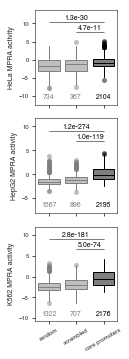

In [43]:
order = ["RANDOM", "SCRAMBLED", "WILDTYPE"]
palette = {"RANDOM": "gray", "SCRAMBLED": "gray", "WILDTYPE": "black"}

f, axarr = plt.subplots(3, sharex=True, sharey=False, figsize=(1.78, 5))
neg_control_plot(pool1_hela_elem_norm, order, palette, fontsize, "HeLa", axarr[0], None, "HeLa MPRA activity", 
                 False, False, False, None)
neg_control_plot(pool1_hepg2_elem_norm, order, palette, fontsize, "HepG2", axarr[1], None, "HepG2 MPRA activity", 
                 False, False, False, None)
neg_control_plot(pool1_k562_elem_norm, order, palette, fontsize, "K562", axarr[2], None, "K562 MPRA activity", 
                 False, False, False, None)
plt.tight_layout()
f.savefig("Fig_1C_S4A.pdf", bbox_inches="tight", dpi="figure")

y_1: 8.5, y_2: 6
rand_pval: 1.32497538616e-30, scram_pval: 4.72968645318e-11
y_1: 8.5, y_2: 6
rand_pval: 1.17132621074e-274, scram_pval: 1.00414951338e-119
y_1: 8.5, y_2: 6
rand_pval: 2.75667614727e-181, scram_pval: 5.01255506218e-74


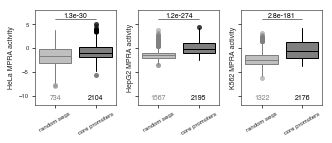

In [44]:
talk_order = ["RANDOM", "WILDTYPE"]
talk_palette = {"RANDOM": "gray", "WILDTYPE": "black"}

f, axarr = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(4.7, 2))
neg_control_plot(pool1_hela_elem_norm, talk_order, talk_palette, fontsize, "HeLa", axarr[0], None, "HeLa MPRA activity", 
                 True, False, False, None)
neg_control_plot(pool1_hepg2_elem_norm, talk_order, talk_palette, fontsize, "HepG2", axarr[1], None, "HepG2 MPRA activity", 
                 True, False, False, None)
neg_control_plot(pool1_k562_elem_norm, talk_order, talk_palette, fontsize, "K562", axarr[2], None, "K562 MPRA activity", 
                 True, False, False, None)
plt.tight_layout()
#plt.ylim((-10, 11))
f.savefig("neg_ctrl_boxplots.for_talk.pdf", bbox_inches="tight", dpi="figure")

### pool 2

y_1: 9.42783493857, y_2: 7.23987496313
rand_pval: 5.11647933556e-17, scram_pval: 7.90973564244e-10
y_1: 8.26308778415, y_2: 5.97168986664
rand_pval: 2.58113913894e-06, scram_pval: 0.00122751191285


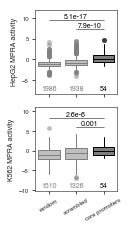

In [45]:
f, axarr = plt.subplots(2, sharex=True, sharey=False, figsize=(1.78, 3.2))
neg_control_plot(pool2_hepg2_elem_norm, order, palette, fontsize, "HepG2", axarr[0], None, "HepG2 MPRA activity", 
                 False, False, False, None)
neg_control_plot(pool2_k562_elem_norm, order, palette, fontsize, "K562", axarr[1], None, "K562 MPRA activity", 
                 False, False, False, None)
plt.tight_layout()
f.savefig("Fig_S8.pdf", bbox_inches="tight", dpi="figure")

## 5. boxplots: across TSS classes

In [46]:
def promtype_plot(df, order, palette, labels, fontsize, cell_type, ax, figsize, ylabel, sharey, title, save, plotname):
    
    df = df[df["better_type"].isin(["WILDTYPE", "SCRAMBLED", "RANDOM"])]
    
    if ax == None:
        plt.figure(figsize=figsize)
        ax = sns.boxplot(data=df, x="PromType2", y="overall_mean", order=order, palette=palette, linewidth=1,
                         saturation=1, flierprops=dict(marker='o', markersize=5))
    else:
        sns.boxplot(ax=ax, data=df, x="PromType2", y="overall_mean", order=order, palette=palette, linewidth=1,
                    saturation=1, flierprops=dict(marker='o', markersize=5))
    
    if "random" in order:
        ax.set_xticklabels(["random", "eRNAs", "lincRNAs", "div. lncRNAs", "mRNAs", "div. mRNAs"], rotation=30)
    elif "scrambled" in order:
        ax.set_xticklabels(["scrambled", "eRNAs", "lincRNAs", "div. lncRNAs", "mRNAs", "div. mRNAs"], rotation=30)
    else:
        ax.set_xticklabels(["eRNAs", "lincRNAs", "div. lncRNAs", "mRNAs", "div. mRNAs"], rotation=30)
    mimic_r_boxplot(ax)
    
    # calc p-vals b/w dists
    if "random" in order:
        rand_dist = np.asarray(df[df["PromType2"] == "random"]["overall_mean"])
        rand_dist = rand_dist[~np.isnan(rand_dist)]
    if "scrambled" in order:
        scram_dist = np.asarray(df[df["PromType2"] == "scrambled"]["overall_mean"])
        scram_dist = scram_dist[~np.isnan(scram_dist)]
        
    enh_dist = np.asarray(df[df["PromType2"] == "Enhancer"]["overall_mean"])
    enh_dist = enh_dist[~np.isnan(enh_dist)]
    
    int_dist = np.asarray(df[df["PromType2"] == "intergenic"]["overall_mean"])
    int_dist = int_dist[~np.isnan(int_dist)]
    
    div_lnc_dist = np.asarray(df[df["PromType2"] == "div_lnc"]["overall_mean"])
    div_lnc_dist = div_lnc_dist[~np.isnan(div_lnc_dist)]
    
    pc_dist = np.asarray(df[df["PromType2"] == "protein_coding"]["overall_mean"])
    pc_dist = pc_dist[~np.isnan(pc_dist)]
    
    div_pc_dist = np.asarray(df[df["PromType2"] == "div_pc"]["overall_mean"])
    div_pc_dist = div_pc_dist[~np.isnan(div_pc_dist)]
    
    if "random" in order:
        # random pvals
        enh_n_u, enh_n_pval = stats.mannwhitneyu(rand_dist, enh_dist, alternative="two-sided", use_continuity=False)
        int_n_u, int_n_pval = stats.mannwhitneyu(rand_dist, int_dist, alternative="two-sided", use_continuity=False)
        div_lnc_n_u, div_lnc_n_pval = stats.mannwhitneyu(rand_dist, div_lnc_dist, alternative="two-sided", use_continuity=False)
        pc_n_u, pc_n_pval = stats.mannwhitneyu(rand_dist, pc_dist, alternative="two-sided", use_continuity=False)
        div_pc_n_u, div_pc_n_pval = stats.mannwhitneyu(rand_dist, div_pc_dist, alternative="two-sided", use_continuity=False)
    
    if "scrambled" in order:
        # scrambled pvals
        enh_n_u, enh_n_pval = stats.mannwhitneyu(scram_dist, enh_dist, alternative="two-sided", use_continuity=False)
        int_n_u, int_n_pval = stats.mannwhitneyu(scram_dist, int_dist, alternative="two-sided", use_continuity=False)
        div_lnc_n_u, div_lnc_n_pval = stats.mannwhitneyu(scram_dist, div_lnc_dist, alternative="two-sided", use_continuity=False)
        pc_n_u, pc_n_pval = stats.mannwhitneyu(scram_dist, pc_dist, alternative="two-sided", use_continuity=False)
        div_pc_n_u, div_pc_n_pval = stats.mannwhitneyu(scram_dist, div_pc_dist, alternative="two-sided", use_continuity=False)
    
    lnc_u, lnc_pval = stats.mannwhitneyu(int_dist, div_lnc_dist, alternative="two-sided", use_continuity=False)
    pc_u, pc_pval = stats.mannwhitneyu(pc_dist, div_pc_dist, alternative="two-sided", use_continuity=False)

    if "random" in order:
        all_dists = list(rand_dist) + list(enh_dist) + list(int_dist) + list(div_lnc_dist) + list(pc_dist) + list(div_pc_dist)
    if "scrambled" in order:
        all_dists = list(scram_dist) + list(enh_dist) + list(int_dist) + list(div_lnc_dist) + list(pc_dist) + list(div_pc_dist)
    else:
        all_dists = list(enh_dist) + list(int_dist) + list(div_lnc_dist) + list(pc_dist) + list(div_pc_dist)
        
    if sharey:
        ax.set_ylim((-20, 10))
        #ax.yaxis.set_ticks(np.arange(-15, 11, 5))
        y_2 = 6
        y_1 = 6
    else:
        ax.set_ylim((np.min(all_dists)-5, np.max(all_dists)+12))
        #ax.yaxis.set_ticks(np.arange(round(np.min(all_dists)-2), round(np.max(all_dists)+3.5), 5))
        y_2 = np.max(pc_dist)+2
        y_1 = np.max(pc_dist)+2
    
        
    # statistical annotation for divergents
    if "random" in order or "scrambled" in order:
        annotate_pval(ax, 2, 3, y_1, 0, 0, lnc_pval, fontsize, True,
                      palette["intergenic"], palette["div_lnc"])
        annotate_pval(ax, 4, 5, y_2, 0, 0, pc_pval, fontsize, True,
                      palette["protein_coding"], palette["div_pc"])
    else:
        annotate_pval(ax, 1, 2, y_1, 0, 0, lnc_pval, fontsize, True,
                      palette["intergenic"], palette["div_lnc"])
        annotate_pval(ax, 3, 4, y_2, 0, 0, pc_pval, fontsize, True,
                      palette["protein_coding"], palette["div_pc"])
    
    # statistical annotation for nulls
    if "random" in order or "scrambled" in order:
        y_1 = np.max(all_dists)+2
        annotate_pval(ax, 0, 1, y_1, 0, 0, enh_n_pval, fontsize, True, 
                      palette["random"], palette["Enhancer"])
        for i, color, p in zip([2,3,4,5],[palette["intergenic"], palette["div_lnc"], palette["protein_coding"], palette["div_pc"]], [int_n_pval, div_lnc_n_pval, pc_n_pval, div_pc_n_pval]):
            # find y_1 by going up from y_2 in axes fraction coords
            x_ax, y_ax = axis_data_coords_sys_transform(ax, 0, y_1, inverse=True)
            y_1_ax = y_ax + 0.08
            x_data, y_1 = axis_data_coords_sys_transform(ax, x_ax, y_1_ax, inverse=False)

            annotate_pval(ax, 0, i, y_1, 0, 0, p, fontsize, True,
                          palette["random"], color)
        
    # reset axlim
    if not sharey:
        x_ax, y_ax = axis_data_coords_sys_transform(ax, 0, y_1, inverse=True)
        x_d, ylim_d = axis_data_coords_sys_transform(ax, 0, y_ax + 0.08, inverse=False)
        ax.set_ylim((np.min(all_dists)-5, ylim_d))
    
    # annotate group #s
    x_ax_0, y_ax = axis_data_coords_sys_transform(ax, 0, 0, inverse=True)
    x_ax_1, y_ax = axis_data_coords_sys_transform(ax, 1, 0, inverse=True)
    x_ax_2, y_ax = axis_data_coords_sys_transform(ax, 2, 0, inverse=True)
    x_ax_3, y_ax = axis_data_coords_sys_transform(ax, 3, 0, inverse=True)
    x_ax_4, y_ax = axis_data_coords_sys_transform(ax, 4, 0, inverse=True)
    x_ax_5, y_ax = axis_data_coords_sys_transform(ax, 5, 0, inverse=True)
    
    
    if "random" in order:
        ax.annotate(str(len(rand_dist)), xy=(x_ax_0, 0.02), xycoords="axes fraction", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=palette["random"], size=fontsize)
    if "scrambled" in order:
        ax.annotate(str(len(scram_dist)), xy=(x_ax_0, 0.02), xycoords="axes fraction", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=palette["scrambled"], size=fontsize)
        
    if "random" not in order and "scrambled" not in order:
        diff = 1/len(order)
    else:
        diff = 0
    ax.annotate(str(len(enh_dist)), xy=(x_ax_1-diff, 0.02), xycoords="axes fraction", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=palette["Enhancer"], size=fontsize)
    ax.annotate(str(len(int_dist)), xy=(x_ax_2-diff, 0.02), xycoords="axes fraction", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=palette["intergenic"], size=fontsize)
    ax.annotate(str(len(div_lnc_dist)), xy=(x_ax_3-diff, 0.02), xycoords="axes fraction", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=palette["div_lnc"], size=fontsize)
    ax.annotate(str(len(pc_dist)), xy=(x_ax_4-diff, 0.02), xycoords="axes fraction", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=palette["protein_coding"], size=fontsize)
    ax.annotate(str(len(div_pc_dist)), xy=(x_ax_5-diff, 0.02), xycoords="axes fraction", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=palette["div_pc"], size=fontsize)
    
    ax.set_ylabel(ylabel)
    ax.set_xlabel("")
    if title:
        ax.set_title("%s" % (cell_type))
    if save:
        plt.savefig("%s/%s.pdf" % (figs_dir, plotname), dpi="figure", bbox_inches="tight")

In [47]:
palette = {"random": "gray", "scrambled": "gray", "Enhancer": sns.color_palette("deep")[1], 
           "intergenic": sns.color_palette("deep")[2], "protein_coding": sns.color_palette("deep")[5], 
           "div_lnc": sns.color_palette("deep")[3], "div_pc": sns.color_palette("deep")[0]}

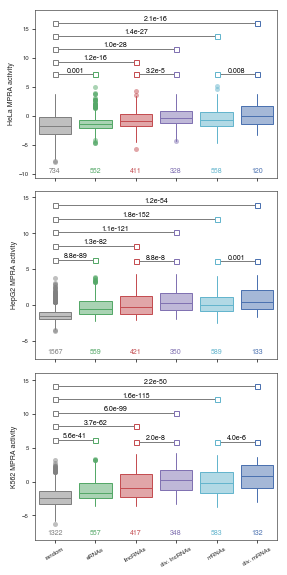

In [48]:
# random
order = ["random", "Enhancer", "intergenic", "div_lnc", "protein_coding", "div_pc"]
labels = ["random", "eRNAs", "lincRNAs", "div. lncRNAs", "mRNAs", "div. mRNAs"]

f, axarr = plt.subplots(3, sharex=True, sharey=False, figsize=(4, 8))
promtype_plot(pool1_hela_df, order, palette, labels, fontsize, "HeLa", axarr[0], None, 
              "HeLa MPRA activity", False, False, False, None)
promtype_plot(pool1_hepg2_df, order, palette, labels, fontsize, "HepG2", axarr[1], None, 
              "HepG2 MPRA activity", False, False, False, None)
promtype_plot(pool1_k562_df, order, palette, labels, fontsize, "K562", axarr[2], None, 
              "K562 MPRA activity", False, False, False, None)
plt.tight_layout()
f.savefig("Fig1_All_Biotypes_v_Random.pdf", bbox_inches="tight", dpi="figure")

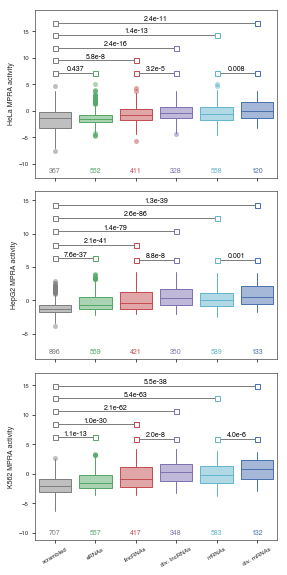

In [49]:
# scrambled
order = ["scrambled", "Enhancer", "intergenic", "div_lnc", "protein_coding", "div_pc"]
labels = ["scrambled", "eRNAs", "lincRNAs", "div. lncRNAs", "mRNAs", "div. mRNAs"]

f, axarr = plt.subplots(3, sharex=True, sharey=False, figsize=(4, 8))
promtype_plot(pool1_hela_df, order, palette, labels, fontsize, "HeLa", axarr[0], None, 
              "HeLa MPRA activity", False, False, False, None)
promtype_plot(pool1_hepg2_df, order, palette, labels, fontsize, "HepG2", axarr[1], None, 
              "HepG2 MPRA activity", False, False, False, None)
promtype_plot(pool1_k562_df, order, palette, labels, fontsize, "K562", axarr[2], None, 
              "K562 MPRA activity", False, False, False, None)
plt.tight_layout()
f.savefig("Fig1_All_Biotypes_v_Scrambled.pdf", bbox_inches="tight", dpi="figure")

## expression-match

In [50]:
def fix_enh_cage_id(row):
    if row.PromType2 == "Enhancer":
        if not pd.isnull(row.enhancer_id_x):
            return row.enhancer_id_x
        elif not pd.isnull(row.enhancer_id_y):
            return row.enhancer_id_y
        else:
            return np.nan
    else:
        return row.cage_id

In [51]:
sel_map["cage_id"] = sel_map["TSS_id"]
sel_map = sel_map.merge(enh_id_map[["TSS_id_Pos", "enhancer_id"]],
                        left_on="TSS_id", right_on="TSS_id_Pos", how="left")
sel_map = sel_map.merge(enh_id_map[["TSS_id_Neg", "enhancer_id"]],
                        left_on="TSS_id", right_on="TSS_id_Neg", how="left")
sel_map["cage_id"] = sel_map.apply(fix_enh_cage_id, axis=1)
sel_map.drop(["TSS_id_Pos", "enhancer_id_x", "TSS_id_Neg", "enhancer_id_y"], axis=1, inplace=True)
sel_map_expr = sel_map.merge(cage_exp, on="cage_id", how="left")
sel_map_expr.sample(5)

,oligo_reg,TSS_id,selected,PromType2,cage_id,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
1031,"chr7:53879598..53879712,-","chr7:53879623..53879635,-",lncRNA,intergenic,"chr7:53879623..53879635,-",1.080379,0.956471,0.666667,189.0,dynamic
1324,"chr2:28617508..28617622,-","chr2:28617533..28617551,-",lncRNA,antisense,"chr2:28617533..28617551,-",0.559017,0.964469,0.666667,337.0,ubiquitous
2789,"chr5:131832624..131832738,+","chr5:131832658..131832659,-",eRNA.expmatch,Enhancer,chr5:131832561-131832909,0.632141,0.964941,0.408589,410.0,ubiquitous
1119,"chr2:25194915..25195029,+","chr2:25194979..25195033,+",lncRNA,div_lnc,"chr2:25194979..25195033,+",4.143903,0.927166,0.146402,543.0,ubiquitous
1195,"chr19:37178274..37178388,-","chr19:37178284..37178348,-",lncRNA,div_lnc,"chr19:37178284..37178348,-",3.783633,0.878080,0.288194,540.0,ubiquitous


In [52]:
sel_map_expr["log_av_exp"] = np.log10(sel_map_expr["av_exp"])
sel_map_expr.selected.unique()

array(['mRNA.random', 'mRNA.gwas', 'mRNA.expmatch', 'mRNA.bidirec70-160',
       'lncRNA', 'control.eQTLprom', 'control.prom', 'lncRNA.gwas',
       'eRNA.random', 'eRNA.expmatch', 'eRNA.gwas', 'eRNA.highlyexp',
       'control.eQTL', 'control.enhancer'], dtype=object)

In [53]:
rand_sel_types = ["lncRNA", "eRNA.random", "mRNA.random", "mRNA.bidirec70-160"]

In [54]:
rand_sel_ids = sel_map_expr[sel_map_expr["selected"].isin(rand_sel_types)]
remaining_ids = sel_map_expr[~sel_map_expr["selected"].isin(rand_sel_types)]
remaining_ids = remaining_ids.append(sel_map_expr[sel_map_expr["selected"] == "lncRNA"])
remaining_ids.selected.value_counts()

lncRNA              1202
mRNA.gwas            318
eRNA.expmatch        308
mRNA.expmatch        232
eRNA.gwas            124
eRNA.highlyexp        72
lncRNA.gwas           14
control.eQTL           8
control.eQTLprom       6
control.prom           4
control.enhancer       2
Name: selected, dtype: int64

In [55]:
def distplot_biotypes(df, figsize, palette, label_dict, ylim, xlabel, save, plotname):
    fig = plt.figure(figsize=figsize)
    df = df.drop_duplicates()
    
    for i, promtype in enumerate(["Enhancer", "intergenic", "div_lnc", "protein_coding", "div_pc"]):
        sub = df[df["PromType2"] == promtype]
        color = palette[promtype]
        label = label_dict[promtype]
        if i == 0:
            ax = sns.kdeplot(sub["log_av_exp"], cumulative=True, color=color, 
                              label="%s (n=%s)" % (label, len(sub)))
        else:
            sns.kdeplot(sub["log_av_exp"], cumulative=True, color=color, 
                         label="%s (n=%s)" % (label, len(sub)), ax=ax)
    
    plt.ylim(ylim)
    plt.xlabel(xlabel)
    plt.ylabel("cumulative density")
    if save:
        fig.savefig("%s.pdf" % plotname, dpi="figure", bbox_inches="tight")

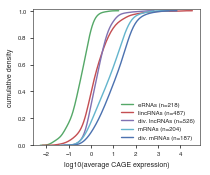

In [56]:
label_dict = {"Enhancer": "eRNAs", "intergenic": "lincRNAs", "div_lnc": "div. lncRNAs", "protein_coding": "mRNAs",
              "div_pc": "div. mRNAs"}
distplot_biotypes(rand_sel_ids, (3, 2.5), palette, label_dict, (0, 1.01), "log10(average CAGE expression)", True, "Random_Sel_Expr_Dist")

In [57]:
remaining_ids.PromType2.value_counts()

div_lnc           526
protein_coding    515
Enhancer          504
intergenic        498
antisense         192
div_pc             45
control            10
Name: PromType2, dtype: int64

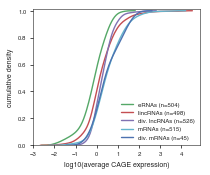

In [58]:
distplot_biotypes(remaining_ids, (3, 2.5), palette, label_dict, (0, 1.01), "log10(average CAGE expression)", False, None)

In [59]:
exp_match_ids = remaining_ids[(remaining_ids["log_av_exp"] > 0) & (remaining_ids["log_av_exp"] < 1.5)]
print("min exp: %s" % (np.min(exp_match_ids["av_exp"])))
print("max exp: %s" % (np.max(exp_match_ids["av_exp"])))
exp_match_ids.PromType2.value_counts()

min exp: 1.00176657185
max exp: 31.4337106382


div_lnc           359
protein_coding    345
intergenic        270
Enhancer          212
antisense         112
div_pc             33
Name: PromType2, dtype: int64

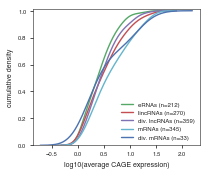

In [60]:
distplot_biotypes(exp_match_ids, (3, 2.5), palette, label_dict, (0, 1.01), "log10(average CAGE expression)", True, "ExpMatch_Sel_Expr_Dist")

In [61]:
pool1_hela_rand = pool1_hela_df[pool1_hela_df["oligo_reg"].isin(rand_sel_ids["oligo_reg"])]
pool1_hepg2_rand = pool1_hepg2_df[pool1_hepg2_df["oligo_reg"].isin(rand_sel_ids["oligo_reg"])]
pool1_k562_rand = pool1_k562_df[pool1_k562_df["oligo_reg"].isin(rand_sel_ids["oligo_reg"])]

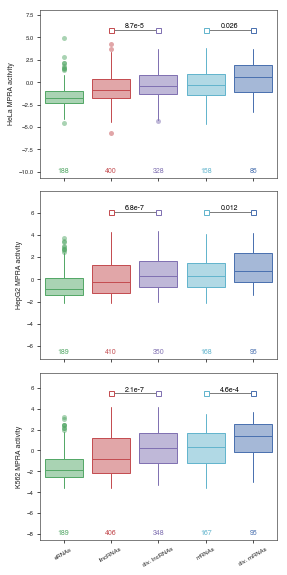

In [62]:
order = ["Enhancer", "intergenic", "div_lnc", "protein_coding", "div_pc"]
labels = ["eRNAs", "lincRNAs", "div. lncRNAs", "mRNAs", "div. mRNAs"]

f, axarr = plt.subplots(3, sharex=True, sharey=False, figsize=(4, 8))
promtype_plot(pool1_hela_rand, order, palette, labels, fontsize, "HeLa", axarr[0], None, 
              "HeLa MPRA activity", False, False, False, None)
promtype_plot(pool1_hepg2_rand, order, palette, labels, fontsize, "HepG2", axarr[1], None, 
              "HepG2 MPRA activity", False, False, False, None)
promtype_plot(pool1_k562_rand, order, palette, labels, fontsize, "K562", axarr[2], None, 
              "K562 MPRA activity", False, False, False, None)
plt.tight_layout()
f.savefig("Fig1_All_Biotypes_Random_Sel.pdf", bbox_inches="tight", dpi="figure")

In [63]:
pool1_hela_exp = pool1_hela_df[pool1_hela_df["oligo_reg"].isin(exp_match_ids["oligo_reg"])]
pool1_hepg2_exp = pool1_hepg2_df[pool1_hepg2_df["oligo_reg"].isin(exp_match_ids["oligo_reg"])]
pool1_k562_exp = pool1_k562_df[pool1_k562_df["oligo_reg"].isin(exp_match_ids["oligo_reg"])]

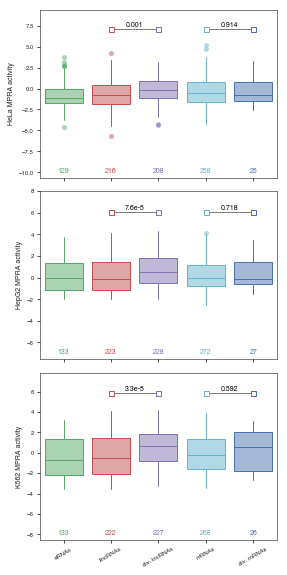

In [64]:
f, axarr = plt.subplots(3, sharex=True, sharey=False, figsize=(4, 8))
promtype_plot(pool1_hela_exp, order, palette, labels, fontsize, "HeLa", axarr[0], None, 
              "HeLa MPRA activity", False, False, False, None)
promtype_plot(pool1_hepg2_exp, order, palette, labels, fontsize, "HepG2", axarr[1], None, 
              "HepG2 MPRA activity", False, False, False, None)
promtype_plot(pool1_k562_exp, order, palette, labels, fontsize, "K562", axarr[2], None, 
              "K562 MPRA activity", False, False, False, None)
plt.tight_layout()
f.savefig("Fig1_All_Biotypes_ExpMatch_Sel.pdf", bbox_inches="tight", dpi="figure")

the rest of the analysis only uses pool 1 (the TSS pool), as it looks at patterns in expression differences between TSS classes

## 6. barplots: find % of sequences active across cell types

In [65]:
pool1_hela_df["cell"] = "HeLa"
pool1_hepg2_df["cell"] = "HepG2"
pool1_k562_df["cell"] = "K562"

all_df = pool1_hela_df[["unique_id", "better_type", "cell", "PromType2", "combined_class", "overall_mean"]].append(pool1_hepg2_df[["unique_id", "better_type", "cell", "PromType2", "combined_class", "overall_mean"]]).append(pool1_k562_df[["unique_id", "better_type", "cell", "PromType2", "combined_class", "overall_mean"]])

In [66]:
df = all_df[all_df["better_type"] == "WILDTYPE"]
activ_grp = df.groupby("unique_id")["cell", "combined_class"].agg(lambda x: list(x)).reset_index()
activ_grp = activ_grp.merge(annot, left_on="unique_id", right_on="seqID", how="left").drop("seqID", axis=1)
activ_grp = activ_grp[(activ_grp["PromType2"].isin(TSS_CLASS_ORDER)) & 
                      ~(activ_grp["unique_id"].str.contains("SCRAMBLED"))]
activ_grp.sample(10)

,unique_id,cell,combined_class,PromType2
2005,WILDTYPE__mrna.flip.sense__chr6:13574753..1357...,"[HeLa, HepG2, K562]","[not sig, sig active, not sig]",protein_coding
323,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr2...,"[HeLa, HepG2, K562]","[sig active, sig active, sig active]",Enhancer
2139,WILDTYPE__mrna.noflip.NA__chr2:136499246..1364...,"[HeLa, HepG2, K562]","[not sig, not sig, not sig]",protein_coding
1506,WILDTYPE__Enhancer.noflip.NA__chr20:2191874..2...,"[HeLa, HepG2, K562]","[not sig, sig active, not sig]",Enhancer
490,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__chr2:...,"[HeLa, HepG2, K562]","[not sig, not sig, not sig]",intergenic
989,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chrX:114...,"[HeLa, HepG2, K562]","[not sig, not sig, not sig]",protein_coding
257,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,"[HeLa, HepG2, K562]","[not sig, not sig, not sig]",Enhancer
1321,WILDTYPE__Enhancer.flip.sense__chr17:75954492....,"[HeLa, HepG2, K562]","[not sig, sig active, sig active]",Enhancer
1615,WILDTYPE__Enhancer.noflip.NA__chr9:132176104.....,"[HeLa, HepG2, K562]","[not sig, not sig, not sig]",Enhancer
1465,WILDTYPE__Enhancer.noflip.NA__chr17:7746046..7...,"[HeLa, HepG2, K562]","[not sig, sig active, sig active]",Enhancer


In [67]:
activ_grp["active_in_only_one"] = activ_grp.apply(active_in_only_one, axis=1)
activ_grp["active_in_only_two"] = activ_grp.apply(active_in_only_two, axis=1)
activ_grp["active_in_only_three"] = activ_grp.apply(active_in_only_three, axis=1)
activ_grp.sample(5)

,unique_id,cell,combined_class,PromType2,active_in_only_one,active_in_only_two,active_in_only_three
1648,WILDTYPE__Lincrna.flip.sense__chr20:37063936.....,"[HeLa, HepG2, K562]","[not sig, sig active, not sig]",intergenic,True,False,False
2147,WILDTYPE__mrna.noflip.NA__chr2:202122754..2021...,"[HeLa, HepG2, K562]","[not sig, sig active, not sig]",protein_coding,True,False,False
292,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,"[HeLa, HepG2, K562]","[not sig, not sig, not sig]",Enhancer,False,False,False
1482,WILDTYPE__Enhancer.noflip.NA__chr1:167587039.....,"[HeLa, HepG2, K562]","[not sig, sig active, sig active]",Enhancer,False,True,False
1154,WILDTYPE__Antisense.noflip.NA__chr1:151319404....,"[HeLa, HepG2, K562]","[not sig, sig active, sig active]",div_lnc,False,True,False


In [68]:
activ_counts_1 = activ_grp.groupby(["PromType2", "active_in_only_one"])["unique_id"].agg("count").reset_index()
activ_pcts_1 = activ_counts_1.groupby("PromType2")["unique_id"].apply(lambda x: 100 * x / float(x.sum()))
activ_counts_1["percent"] = activ_pcts_1

activ_counts_2 = activ_grp.groupby(["PromType2", "active_in_only_two"])["unique_id"].agg("count").reset_index()
activ_pcts_2 = activ_counts_2.groupby("PromType2")["unique_id"].apply(lambda x: 100 * x / float(x.sum()))
activ_counts_2["percent"] = activ_pcts_2

activ_counts_3 = activ_grp.groupby(["PromType2", "active_in_only_three"])["unique_id"].agg("count").reset_index()
activ_pcts_3 = activ_counts_3.groupby("PromType2")["unique_id"].apply(lambda x: 100 * x / float(x.sum()))
activ_counts_3["percent"] = activ_pcts_3

activ_counts_1 = activ_counts_1[activ_counts_1["active_in_only_one"]]
activ_counts_2 = activ_counts_2[activ_counts_2["active_in_only_two"]]
activ_counts_3 = activ_counts_3[activ_counts_3["active_in_only_three"]]

activ_counts = activ_counts_1.merge(activ_counts_2, on="PromType2").merge(activ_counts_3, on="PromType2")
activ_counts.drop(["active_in_only_one", "unique_id_x", "active_in_only_two", "unique_id_y", 
                   "active_in_only_three", "unique_id"],
                  axis=1, inplace=True)
activ_counts.columns = ["PromType2", "active_in_only_one", "active_in_only_two", "active_in_only_three"]
activ_counts = pd.melt(activ_counts, id_vars="PromType2")
activ_counts.head()

,PromType2,variable,value
0,Enhancer,active_in_only_one,25.886525
1,div_lnc,active_in_only_one,16.997167
2,div_pc,active_in_only_one,7.299270
3,intergenic,active_in_only_one,18.352941
4,protein_coding,active_in_only_one,16.193656


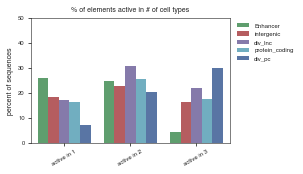

In [69]:
df = activ_counts[activ_counts["PromType2"] != "antisense"]
df["PromType2"] = pd.Categorical(df["PromType2"], TSS_CLASS_ORDER)
df.sort_values(by="PromType2")

plt.figure(figsize=(3.56, 2.3))
ax = sns.barplot(data=df, x="variable", y="value", hue="PromType2", ci=None, palette=TSS_CLASS_PALETTE)
ax.set_xticklabels(["active in 1", "active in 2", "active in 3"], rotation=30)

plt.legend(bbox_to_anchor=(1.35, 1))
plt.ylim((0, 50))
plt.ylabel("percent of sequences", size=fontsize)
plt.xlabel("")
plt.title("% of elements active in # of cell types")

In [70]:
colors = []
for c in TSS_CLASS_ORDER:
    colors.append(TSS_CLASS_PALETTE[c])
colors

[(0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.6980392156862745),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451),
 (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)]

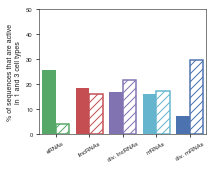

In [71]:
# better plot showing tissue sp
df = activ_counts[activ_counts["PromType2"] != "antisense"]
df["PromType2"] = pd.Categorical(df["PromType2"], TSS_CLASS_ORDER)
df.sort_values(by="PromType2")

plt.figure(figsize=(3,2.3))
ax = sns.barplot(data=df[df["variable"]!="active_in_only_two"], x="PromType2", y="value", 
                 ci=None, hue="variable", linewidth=1.5)
ax.set_xticklabels(["eRNAs", "lincRNAs", "div. lncRNAs", "mRNAs", "div. mRNAs"], rotation=30)

colors = colors*2
for i, p in enumerate(ax.patches):
    if i < 5:
        p.set_facecolor(colors[i])
    else:
        p.set_facecolor("white")
        p.set_edgecolor(colors[i])
        p.set_alpha(1)
        p.set_hatch("///")

ax.legend().set_visible(False)
plt.ylim((0, 50))
plt.ylabel("% of sequences that are active\nin 1 and 3 cell types", fontsize=fontsize)
plt.xlabel("")
plt.savefig("Fig_1F.pdf", bbox_inches="tight", dpi="figure")

## 7. kdeplot: compare to CAGE

In [72]:
hepg2_activ = pool1_hepg2_df[["unique_id", "element", "better_type", "overall_mean", "PromType2"]]
hela_activ = pool1_hela_df[["unique_id", "element", "better_type", "overall_mean"]]
k562_activ = pool1_k562_df[["unique_id", "element", "better_type", "overall_mean"]]

all_activ = hepg2_activ.merge(hela_activ, on=["unique_id", "element", "better_type"], how="left").merge(k562_activ, on=["unique_id", "element", "better_type"], how="left")
all_activ.columns = ["unique_id", "element", "better_type", "HepG2", "PromType2", "HeLa", "K562"]
all_activ = all_activ[["unique_id", "element", "better_type", "PromType2", "HepG2", "HeLa", "K562"]]
all_activ = all_activ[(all_activ["PromType2"].isin(TSS_CLASS_ORDER)) & 
                      ~(all_activ["unique_id"].str.contains("SCRAMBLED")) &
                      (all_activ["better_type"] == "WILDTYPE")]
all_activ.sample(5)

,unique_id,element,better_type,PromType2,HepG2,HeLa,K562
7121,WILDTYPE__mrna.noflip.NA__chr7:24323729..24323...,ACCCAAGCGTGACTGCCCGAGGCCCCTCCTGCCGCGGCGAGGAAGC...,WILDTYPE,protein_coding,-0.809635,NaN,-1.139198
6231,WILDTYPE__Enhancer.flip.sense__chr12:121714973...,AAAGGGAAAACCCAACGCCCCAGCCCTGACACGGGCCTGACTCATG...,WILDTYPE,Enhancer,-0.883996,-2.282632,-2.585764
3556,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr9...,TGTGGAACAGTTTGTCCTTTTTACTCTCCGCCCCCCCCGCCCCGTC...,WILDTYPE,Enhancer,1.135359,-0.194510,2.660977
3730,WILDTYPE_BUT_HAS_SNP__mrna.flip.sense__chr11:2...,GGCTGGGCTATCTAGGGGCGTGGTCGGTGCGGAGGCGGGGCCATCG...,WILDTYPE,protein_coding,2.316493,1.235468,2.867475
3841,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr11:64...,GAGAGAGCTCGCCGTCGCTCCGTCATAGAGTTCGCCCCACCCCATC...,WILDTYPE,div_pc,-0.231817,-1.227104,-0.032716


In [73]:
all_activ["combined_class"] = ""
all_activ = all_activ.merge(pool1_hela_elem_norm[["unique_id", "element", "combined_class"]], on=["unique_id", "element"], how="left", suffixes=("", "_HeLa")).merge(pool1_hepg2_elem_norm[["unique_id", "element", "combined_class"]], on=["unique_id", "element"], how="left", suffixes=("", "_HepG2")).merge(pool1_k562_elem_norm[["unique_id", "element", "combined_class"]], on=["unique_id", "element"], how="left", suffixes=("", "_K562"))
all_activ.drop("combined_class", axis=1, inplace=True)
all_activ.head()

,unique_id,element,better_type,PromType2,HepG2,HeLa,K562,combined_class_HeLa,combined_class_HepG2,combined_class_K562
0,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,GGTGGGCCCCCTCCCCCTTCTTCCGGCGGGCCTCCTCCCTCCCCTT...,WILDTYPE,intergenic,2.688943,-0.470427,1.981653,sig active,sig active,sig active
1,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,GACTAAATAAGGGAGGCTGCAGCGGCTGCGCGTGCGCCCAGAGGCG...,WILDTYPE,div_lnc,-0.701841,0.371693,0.166442,not sig,sig active,not sig
2,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,AACTCGCCCTCCGGAAAGACGCGGGGGAATTCTGGGAGTGCGCGGC...,WILDTYPE,intergenic,1.704007,0.456156,1.976386,sig active,sig active,sig active
3,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,CACCAACCGCCCCACCGCACCCTGCGCCAGCCCTACGGCGCCCGCG...,WILDTYPE,intergenic,-0.022075,1.114820,-0.701002,not sig,sig active,not sig
4,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,AGACCCACAGGAAATGACGACAGAAGGGCTGAGGTGGGGGGGCGGG...,WILDTYPE,div_lnc,3.759629,2.141635,3.237685,sig active,sig active,sig active


In [74]:
all_activ["oligo_reg"] = all_activ.unique_id.str.split("__", expand=True)[2]
all_activ.sample(5)

,unique_id,element,better_type,PromType2,HepG2,HeLa,K562,combined_class_HeLa,combined_class_HepG2,combined_class_K562,oligo_reg
671,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr15:10...,CGGGCGCTGATTGGTTGTTGAAGGCTTGGTCCCATCCCAGTGACCC...,WILDTYPE,protein_coding,0.310751,-2.507983,-2.750993,not sig,sig active,not sig,"chr15:101142755..101142869,+"
1552,WILDTYPE__Lincrna.noflip.NA__chr11:122238545.....,GAGCCTGTCAAGCTATGTTTGAACTCGTTCCAGGATAGTGGATTTA...,WILDTYPE,intergenic,-0.981307,-0.940556,-1.862793,not sig,not sig,not sig,"chr11:122238545..122238659,-"
1609,WILDTYPE__Lincrna.noflip.NA__chr1:235116488..2...,TGAGTGTCTGCTTCCTCTCTGACTCAGGATTGGATCTGTTTCTGAG...,WILDTYPE,intergenic,-1.363238,-0.714371,-2.854139,not sig,not sig,not sig,"chr1:235116488..235116602,-"
445,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__chr2:...,CGGAGCTAGGGAAGGGGTGGGGGATGGTGGTGGAGGGGAGCTAGCA...,WILDTYPE,intergenic,-1.036846,0.914472,-1.610179,not sig,not sig,not sig,"chr2:238343430..238343544,-"
56,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__chr...,TTAAACCTCCCGCCCACCTTTTCTTTAGACCCGCGTCTCACCCCGG...,WILDTYPE,div_lnc,-0.679666,-1.808809,-0.828042,not sig,sig active,sig active,"chr11:77850775..77850889,+"


In [75]:
id_map = id_map[["oligo_reg", "K562_rep1", "K562_rep2", "K562_rep3", "HeLa_rep1", "HeLa_rep2", "HeLa_rep3", 
                 "HepG2_rep1", "HepG2_rep2", "HepG2_rep3"]]
all_activ = all_activ.merge(id_map, on="oligo_reg")
all_activ.sample(5)

,unique_id,element,better_type,PromType2,HepG2,HeLa,K562,combined_class_HeLa,combined_class_HepG2,combined_class_K562,oligo_reg,K562_rep1,K562_rep2,K562_rep3,HeLa_rep1,HeLa_rep2,HeLa_rep3,HepG2_rep1,HepG2_rep2,HepG2_rep3
1948,WILDTYPE__mrna.noflip.NA__chr16:67840396..6784...,ATTGGCTGAGCGGGGCGGATCTGGTCCCGCTCCTCCCCGCCCCCAG...,WILDTYPE,protein_coding,3.200275,2.065752,2.590279,sig active,sig active,sig active,"chr16:67840396..67840510,-",0.000000,0.196063,0.167822,0.096756,0.073089,0.000000,0.157566,0.164832,0.134807
168,WILDTYPE_BUT_HAS_SNP__Enhancer.flip.sense__chr...,CCGTCCGCGTGTGAGCAGCGCGCACGCGCACGCAATGCGCCTCAAC...,WILDTYPE,Enhancer,0.886394,-1.502220,1.033683,not sig,sig active,sig active,"chr9:140024178..140024292,+",26.599586,19.290616,22.889698,12.903900,11.907773,12.347770,21.509006,20.747302,20.798214
1141,WILDTYPE__Antisense.noflip.NA__chr9:86323150.....,GTCACGGTTAGCGAAATTACTAGAAAGGGACCAGTGGGCCCTGCGG...,WILDTYPE,div_lnc,-0.178913,-1.906003,-0.760599,not sig,sig active,sig active,"chr9:86323150..86323264,+",0.676787,0.784250,0.839108,0.677294,0.803982,0.410577,1.102965,0.824159,0.741439
1295,WILDTYPE__Enhancer.noflip.NA__chr15:60547657.....,TGCATTTCCATGCATAACCAGTGTGACTTATGTTGGTCATATCAGG...,WILDTYPE,Enhancer,-1.832938,-3.028045,-2.151168,not sig,not sig,not sig,"chr15:60547657..60547771,-",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
292,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr3...,TTCACGCTGCAGACGTGCACGGAAGCTGCTTTGGCCAGGGGTTTGG...,WILDTYPE,Enhancer,-0.303878,-0.423429,-1.612627,not sig,sig active,not sig,"chr3:152878296..152878410,+",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078887,0.258363


In [76]:
all_activ["K562_av"] = all_activ[["K562_rep1", "K562_rep2", "K562_rep3"]].mean(axis=1)
all_activ["HeLa_av"] = all_activ[["HeLa_rep1", "HeLa_rep2", "HeLa_rep3"]].mean(axis=1)
all_activ["HepG2_av"] = all_activ[["HepG2_rep1", "HepG2_rep2", "HepG2_rep3"]].mean(axis=1)

all_activ["K562_log_av"] = np.log(all_activ["K562_av"]+1)
all_activ["HeLa_log_av"] = np.log(all_activ["HeLa_av"]+1)
all_activ["HepG2_log_av"] = np.log(all_activ["HepG2_av"]+1)

In [77]:
all_activ = all_activ[(~all_activ["unique_id"].str.contains("SNP_INDIV")) & 
                      (~all_activ["unique_id"].str.contains("SNP_PLUS_HAPLO")) & 
                      (~all_activ["unique_id"].str.contains("FLIPPED"))]
all_activ.sample(5)

,unique_id,element,better_type,PromType2,HepG2,HeLa,K562,combined_class_HeLa,combined_class_HepG2,combined_class_K562,...,HeLa_rep3,HepG2_rep1,HepG2_rep2,HepG2_rep3,K562_av,HeLa_av,HepG2_av,K562_log_av,HeLa_log_av,HepG2_log_av
408,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__chr14...,CAGCTGACTCACTCTCCCAGCAAACACCAGCTCCTCCCCGAGCCAG...,WILDTYPE,intergenic,0.970975,-1.661070,-1.463352,not sig,sig active,not sig,...,0.985385,0.000000,0.082416,0.134807,0.000000,0.757020,0.072408,0.000000,0.563619,0.069906
1293,WILDTYPE__Enhancer.noflip.NA__chr15:52580673.....,GGAGGGGACAGGAATGAATGGGTGGAACTTACCCGGAGCTGAGTAA...,WILDTYPE,Enhancer,-0.610620,-1.323272,-2.325299,not sig,sig active,not sig,...,0.235945,0.599554,0.473322,0.258363,0.000000,0.125622,0.443747,0.000000,0.118335,0.367241
932,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr9:131...,CGGGTCGCAGTAGGCTGGCTGCGAGTCGGGGGCGGGACCACGGCGG...,WILDTYPE,protein_coding,1.044502,-0.833393,1.540962,not sig,sig active,sig active,...,0.739039,2.757411,2.554892,3.100563,0.973053,0.813195,2.804289,0.679582,0.595090,1.336129
1751,WILDTYPE__Lincrna.noflip.NA__chr9:132044709..1...,CTGTGGGTGGAGACACATCTGACGGGAGGGATTTGGATCCTGCCAG...,WILDTYPE,intergenic,-0.919316,-3.130830,-2.582192,not sig,sig active,not sig,...,0.000000,0.078783,0.082416,0.000000,0.000000,0.000000,0.053733,0.000000,0.000000,0.052339
1974,WILDTYPE__mrna.noflip.NA__chr1:155278467..1552...,CTTCAGCCCTTCCATTGGTCGTCCGTCACAGTGCCACAGTGCGCCA...,WILDTYPE,protein_coding,0.318142,0.114313,0.730045,not sig,sig active,sig active,...,1.149616,0.078783,0.576911,0.606632,0.233176,1.208071,0.420775,0.209593,0.792119,0.351203


In [78]:
# first scale mpra ranges to be positive
all_activ["hepg2_scaled"] = scale_range(all_activ["HepG2"], 0, 100)
all_activ["hela_scaled"] = scale_range(all_activ["HeLa"], 0, 100)
all_activ["k562_scaled"] = scale_range(all_activ["K562"], 0, 100)

In [79]:
cage_ts = calculate_tissue_specificity(all_activ[["HepG2_log_av", "K562_log_av", "HeLa_log_av"]])
all_activ["cage_activ"] = all_activ[["HepG2_log_av", "K562_log_av", "HeLa_log_av"]].mean(axis=1)
all_activ["cage_ts"] = cage_ts

mpra_ts = calculate_tissue_specificity(all_activ[["hepg2_scaled", "k562_scaled", "hela_scaled"]])
all_activ["mpra_activ"] = all_activ[["HepG2", "K562", "HeLa"]].mean(axis=1)
all_activ["mpra_ts"] = mpra_ts
all_activ.head()

,unique_id,element,better_type,PromType2,HepG2,HeLa,K562,combined_class_HeLa,combined_class_HepG2,combined_class_K562,...,K562_log_av,HeLa_log_av,HepG2_log_av,hepg2_scaled,hela_scaled,k562_scaled,cage_activ,cage_ts,mpra_activ,mpra_ts
0,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,GGTGGGCCCCCTCCCCCTTCTTCCGGCGGGCCTCCTCCCTCCCCTT...,WILDTYPE,intergenic,2.688943,-0.470427,1.981653,sig active,sig active,sig active,...,5.406185,0.000000,0.025922,76.188273,47.913344,71.954421,1.810702,0.665068,1.400056,0.142230
1,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,GACTAAATAAGGGAGGCTGCAGCGGCTGCGCGTGCGCCCAGAGGCG...,WILDTYPE,div_lnc,-0.701841,0.371693,0.166442,not sig,sig active,not sig,...,0.684124,0.900545,1.024832,26.698185,55.709983,48.891741,0.869834,0.151243,-0.054568,0.214384
2,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,AACTCGCCCTCCGGAAAGACGCGGGGGAATTCTGGGAGTGCGCGGC...,WILDTYPE,intergenic,1.704007,0.456156,1.976386,sig active,sig active,sig active,...,2.740342,2.511808,3.443071,61.812671,56.491967,71.887500,2.898407,0.158191,1.378850,0.118103
3,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,CACCAACCGCCCCACCGCACCCTGCGCCAGCCCTACGGCGCCCGCG...,WILDTYPE,intergenic,-0.022075,1.114820,-0.701002,not sig,sig active,not sig,...,2.012675,2.514709,1.958286,36.619685,62.590112,37.870653,2.161890,0.140302,0.130581,0.269957
4,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,AGACCCACAGGAAATGACGACAGAAGGGCTGAGGTGGGGGGGCGGG...,WILDTYPE,div_lnc,3.759629,2.141635,3.237685,sig active,sig active,sig active,...,1.126949,1.512361,0.572818,91.815440,72.096713,87.912612,1.070710,0.292028,3.046316,0.085757


In [80]:
cmap = sns.light_palette("darkslategray", as_cmap=True)

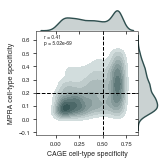

In [81]:
no_nan = all_activ[(~pd.isnull(all_activ["mpra_ts"])) & (~pd.isnull(all_activ["cage_ts"]))]
g = sns.jointplot(data=no_nan, x="cage_ts", y="mpra_ts", kind="kde", shade_lowest=False, size=2.3, space=0,
                  stat_func=None, cmap=cmap, color="darkslategrey")
g.ax_joint.axhline(y=0.2, color="black", linewidth=1, linestyle="dashed")
g.ax_joint.axvline(x=0.5, color="black", linewidth=1, linestyle="dashed")
g.set_axis_labels("CAGE cell-type specificity", "MPRA cell-type specificity")
r, p = stats.spearmanr(no_nan["cage_ts"], no_nan["mpra_ts"])
g.ax_joint.annotate("r = {:.2f}\np = {:.2e}".format(r, Decimal(p)), xy=(.1, .8), xycoords=ax.transAxes, 
                    fontsize=5)
g.savefig("Fig_1E.pdf", bbox_inches="tight", dpi="figure")

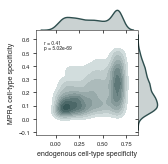

In [82]:
no_nan = all_activ[(~pd.isnull(all_activ["mpra_ts"])) & (~pd.isnull(all_activ["cage_ts"]))]
g = sns.jointplot(data=no_nan, x="cage_ts", y="mpra_ts", kind="kde", shade_lowest=False, size=2.3, space=0,
                  stat_func=None, cmap=cmap, color="darkslategrey")
g.set_axis_labels("endogenous cell-type specificity", "MPRA cell-type specificity")
r, p = stats.spearmanr(no_nan["cage_ts"], no_nan["mpra_ts"])
g.ax_joint.annotate("r = {:.2f}\np = {:.2e}".format(r, Decimal(p)), xy=(.1, .75), xycoords=ax.transAxes, 
                    fontsize=5)
g.savefig("cage_mpra_corr.for_talk.pdf", bbox_inches="tight", dpi="figure")

In [83]:
def cage_v_mpra_ts(row):
    if row["cage_ts"] > 0.5 and row["mpra_ts"] > 0.2:
        return "ts in both"
    elif row["cage_ts"] > 0.5 and row["mpra_ts"] <= 0.2:
        return "ts in cage, not mpra"
    elif row["cage_ts"] <= 0.5 and row["mpra_ts"] > 0.2:
        return "ts in mpra, not cage"
    else:
        return "not ts in both"
    
no_nan["ts_status"] = no_nan.apply(cage_v_mpra_ts, axis=1)
no_nan.ts_status.value_counts()

not ts in both          692
ts in both              402
ts in mpra, not cage    310
ts in cage, not mpra    236
Name: ts_status, dtype: int64

In [84]:
tot = 692+402+310+236
upper_left = 310
upper_right = 402
lower_left = 692
lower_right = 236
print("upper left: %s" % (upper_left/tot))
print("upper right: %s" % (upper_right/tot))
print("lower left: %s" % (lower_left/tot))
print("lower right: %s" % (lower_right/tot))

upper left: 0.18902439024390244
upper right: 0.2451219512195122
lower left: 0.4219512195121951
lower right: 0.14390243902439023


In [85]:
(692+402)/(692+402+310+236)

0.6670731707317074

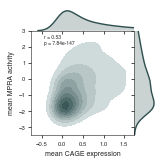

In [86]:
no_nan = all_activ[(~pd.isnull(all_activ["mpra_activ"])) & (~pd.isnull(all_activ["cage_activ"]))]
g = sns.jointplot(data=no_nan, x="cage_activ", y="mpra_activ", kind="kde", shade_lowest=False, size=2.3, space=0,
                  stat_func=None, xlim=(-0.75, 1.75), ylim=(-3.5, 3), cmap=cmap, color="darkslategray")
g.set_axis_labels("mean CAGE expression", "mean MPRA activity")
r, p = stats.spearmanr(no_nan["cage_activ"], no_nan["mpra_activ"])
g.ax_joint.annotate("r = {:.2f}\np = {:.2e}".format(r, Decimal(p)), xy=(.1, .8), xycoords=ax.transAxes, 
                    fontsize=5)

In [87]:
# write file with tissue-specificities for later use
final = all_activ[["unique_id", "PromType2", "cage_activ", "cage_ts", "mpra_activ", "mpra_ts"]]
final.to_csv("../../data/02__activs/POOL1__pMPRA1__CAGE_vs_MPRA_activs.txt", sep="\t", index=False)

In [88]:
# also write file with tss types
sel_map_expr.to_csv("../../misc/00__tss_properties/CAGE_expr_properties.txt", sep="\t", index=False)